In [34]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

os.chdir("../")

from src.perturb import perturb as ppt
from src.piecewise_linear import build_piecewise_linear
from src.piecewise_linear import create_basis
from src.piecewise_linear import piecewise_linear
import src.cont_support as cont_src
from patsy import dmatrix
import pytensor
import pytensor.tensor as pt
import arviz as az
import warnings

300


/Users/maximus/Desktop/tvs_regression/src/perturb.py:79: RuntimeWarning: Mean of empty slice
  x_s = np.nanmean(X_s, axis=0)


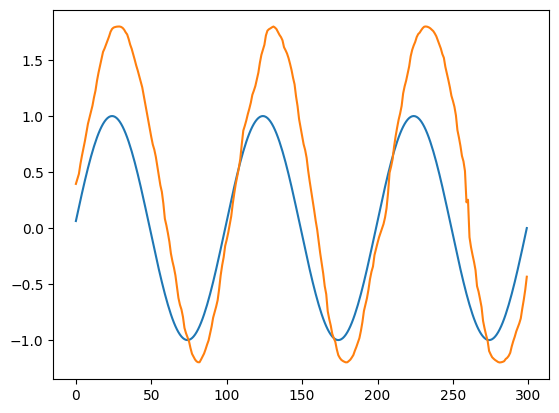

In [5]:
# Load the lynx trapping dataset
#lynx = pd.read_csv("/Users/maximus/Desktop/tvs_regression/lynx.csv")

##lynx.shape[0]
#lynx = lynx.loc[:,['x','year']]

n=300
sr=10
z, x, y1 = cont_src.generate_example_waves(n)

# %%
p, p_cum = cont_src.generate_sample_perturbations(6, n, truncate=False, sr=sr)
print(len(p_cum))

y = ppt(x, p_cum, sr)
y = 1.5*y + 0.3

plt.plot(x)
plt.plot(y)
plt.show()

In [49]:
#lynx.head()
#lynx.shape

(114, 2)

In [50]:
##def generate_example_waves(n):
    #x = np.arange(0,n)/n*12
    #x = 2*np.pi*x
    #y = np.sin(x - 15)*1000
    #return y

#x_in = generate_example_waves(114)

# Add to the dataframe
#lynx['x_in'] = x_in


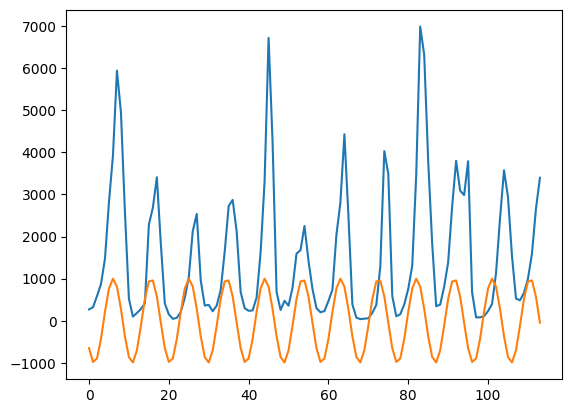

In [78]:
#plt.plot(lynx['x'])
#plt.plot(lynx['x_in'])
#plt.show()

# Convert params to numpy arrays
#y = np.array(lynx['x'])
#x = np.array(lynx['x_in'])

In [55]:
def pdf_normal(x, sd, discrete=False):
    if discrete is True:
        x = np.round(x)
    return -(0.5 / sd**2) * np.sum((x) ** 2)


def upsample(x, sr):
    n = len(x)
    x_i = np.repeat(np.nan, n*sr)
    pos = np.arange(0, n)*sr
    np.put(x_i, pos , x)
    return x_i

# Take the wave and multiply it by its 1.T to get a square sparse matrix decomposition
def matrix_decomp(x, n, sr):
    ones = np.repeat(1, n*sr)
    # Create 1.T
    ones = ones[np.newaxis,:]
    x = x[:, np.newaxis]
    X = np.dot(x, ones)
    I = np.identity(n*sr)
    I[I == 0] = np.nan
    X = X*I
    return X

def shift(x: np.array, k=1):
    ''' shift the arrays'''
    if k > 0:
        y = np.concatenate([np.repeat(np.nan, k), x])
        y = y[:len(x)]
    elif k < 0:
        k = np.abs(k)
        y = np.concatenate([x, np.repeat(np.nan, k)])
        y = y[k:]
    else:
        y = x
    return y

def X_shift(X, sr, p):
    # First enlarge the array to include the largest positive time shift
    if np.max(p) > 0:
        X_out = np.pad(X,[(0,0),(0,np.max(p))], mode='constant', constant_values=np.nan)
    else:
        X_out = X
    # Shift the values
    for i in np.arange(1, len(p)):
        x_r = X_out[i*sr,:]
        x_shift = shift(x_r, p[i])
        X_out[i*sr,:] = x_shift

    return X_out

def ffl_interpolation(x, size):
    ''' Fill forward linear interpolation function using numpy methods'''
    nan_idx = np.isnan(x)
    y = np.arange(len(x))
    x[nan_idx] = np.interp(y[nan_idx], y[~nan_idx], x[~nan_idx])
    return x[:size]


def perturb(x, p, sr):
    ''' Perturb a discrete, contiguous vector with a given perturbation profile and sample rate
    
    Inputs:
        x: Input vector to be perturbed
        p: Cumulative perturbation profile
        sr: Sample rate for upsampling. sr=10 fills 9 nan values between each element
    
    Returns:
        The perturbed vector in its original sample rate.
    '''

    if len(x) != len(p):
        raise("Error: given perturbation length does not equal the input vector length")

 
    # Upsample
    x_i = upsample(x, sr)

 
    # Decompose to sparse matrix form
    n = len(x)
    X = matrix_decomp(x_i, n, sr)

    # Apply shifts
    X_s = X_shift(X.copy(), sr, p)

    # Reduce
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x_s = np.nanmean(X_s, axis=0)

    # Linearly interpolate
    x_out = ffl_interpolation(x_s, n*sr)
    # Downsample and return
    return x_out[np.arange(0,n)*sr]


def custom_likelihood(theta, x, data):
    #B, T_B, c = theta
    #y_p, p = custom_likelihood(x, B, T_B, c, sr)
    # Log normal likelihood for the y-axis error
    m, c, sigma, sigma_ts, w1, w2, w3, w4 = theta
    
    W_T = np.array([w1, w2, w3, w4])

    k = np.linspace(0,len(x), num=4)
    t = np.arange(0, len(x))
    #b = create_basis(t, k = k)

    b = np.empty((len(x), len(k)))
    for i in range(0,len(k)):
    #    #b_i = piecewise_linear(t, k[i])
        b_i = t - k[i]
        b_i = np.where(t < 0, 0, b_i)
        b_i[[t < k[i] for t in t]] = 0
        b[:,i] = b_i

    #print(b.shape)
    #print(W_T.shape)
    # Dot product between weights and basis functions
    p = np.dot(b, W_T)
    
    x_shift = perturb(x, p.astype("int"), sr=10)

    #raise("debug break")
    # Create the shift sequence
    #p = build_piecewise_linear(length=len(x), weights=W_T, n_basis=W_T.shape[0])

    y_p = m*x_shift + c

    e_l = pdf_normal(data - y_p, sigma, discrete=False)
    # Log normal likelihood for the t-axis shifts
    #t_l = np.sum(-1*pdf_normal(np.diff(p), t_sigma, discrete=True, log=True))
    #l = e_l + t_l
    return e_l





In [56]:
def my_model(theta, x):
    m, c = theta
    return m * x + c


def my_loglike(theta, x, data, sigma):
    model = my_model(theta, x)
    return -(0.5 / sigma**2) * np.sum((data - model) ** 2)


# define a pytensor Op for our likelihood function
class LogLike(pt.Op):

    """
    Specify what type of object will be passed and returned to the Op when it is
    called. In our case we will be passing it a vector of values (the parameters
    that define our model) and returning a single "scalar" value (the
    log-likelihood)
    """

    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data)

        outputs[0][0] = np.array(logl)  # output the log-likelihood

Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [m]
>Slice: [c]
>Slice: [sigma]
>Slice: [sigma_ts]
>Slice: [w1]
>Slice: [w2]
>Slice: [w3]
>Slice: [w4]


Sampling 4 chains for 50 tune and 200 draw iterations (200 + 800 draws total) took 13884 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


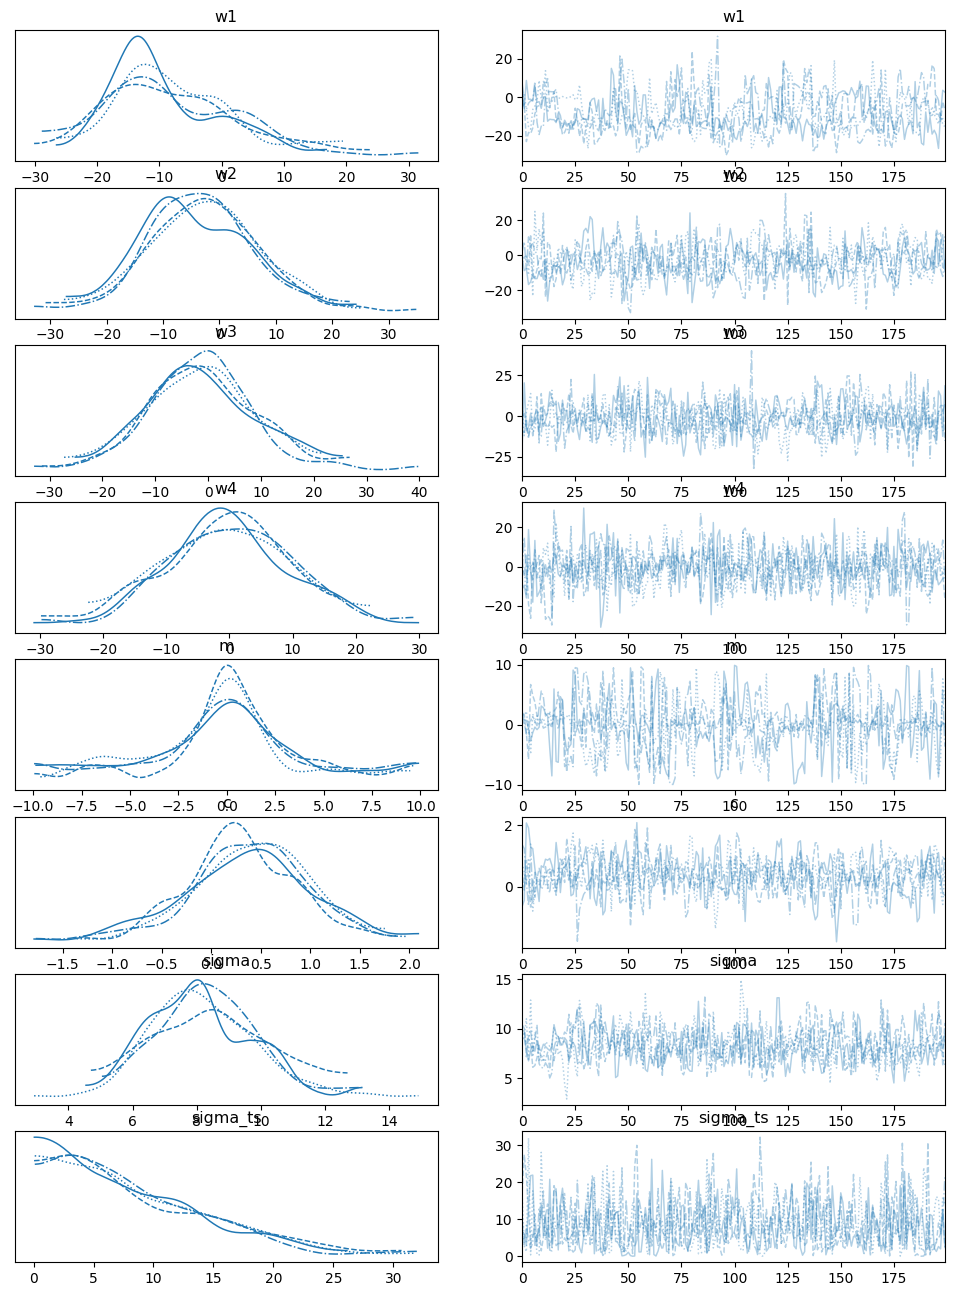

In [57]:

# make data
rng = np.random.default_rng(716743)
data = y

# create our Op
logl = LogLike(custom_likelihood, data, x)

# use PyMC to sampler from log-likelihood
with pm.Model():
    # uniform priors on m and c
    m = pm.Uniform("m", lower=-10.0, upper=10.0)
    c = pm.Uniform("c", lower=-10.0, upper=10.0)
    sigma = pm.HalfNormal("sigma", sigma=3)
    sigma_ts = pm.HalfNormal("sigma_ts", sigma=10)

    # Shift weights
    w1 = pm.Normal("w1", mu=0, sigma=10)
    w2 = pm.Normal("w2", mu=0, sigma=10)
    w3 = pm.Normal("w3", mu=0, sigma=10)
    w4 = pm.Normal("w4", mu=0, sigma=10)

    # convert m and c to a tensor vector
    theta = pt.as_tensor_variable([m, c, sigma, sigma_ts, w1, w2, w3, w4])

    # use a Potential to "call" the Op and include it in the logp computation
    pm.Potential("likelihood", logl(theta))

    # Use custom number of draws to replace the HMC based defaults
    idata_mh = pm.sample(200, tune=50)

# plot the traces
az.plot_trace(idata_mh);

In [68]:
np.mean(idata_mh['posterior']['m'], axis=0)

<xarray.DataArray 'm' (draw: 200)>
array([ 1.46634011,  1.10895677, -0.00682992, -1.67506464, -0.07329885,
        1.67450159,  1.0795846 ,  0.50030097,  0.9006479 ,  2.50896035,
        2.00549272,  0.67351453,  0.75477503,  0.07068233, -1.959916  ,
        2.85617578, -0.12917167, -0.22948271,  2.2213574 ,  2.8226707 ,
       -2.78068767, -4.35455483, -2.73095774, -2.909008  ,  2.06775743,
        4.18479031,  2.15786422,  0.74954089, -0.25512126,  2.14236507,
       -0.21484454,  2.03650643,  0.63072535, -1.62499149, -3.09449552,
       -1.77577378, -1.58533802, -1.69831991,  2.30337798, -3.21866197,
       -0.73790555,  2.53474152,  2.10862854,  3.26019427,  0.43812038,
       -2.03409227, -1.27935409,  1.96118277,  0.12270889, -0.98980757,
       -1.60034425,  3.80892716,  4.67065345, -2.85326777, -3.59249399,
       -3.51715031,  1.6587924 ,  1.73077614, -0.60444035, -2.55246744,
       -3.91330968,  3.63514853, -4.45731807, -1.93484795, -0.79983311,
       -2.92076412,  1.97821414, -1.12855499, -0.28852337, -4.87858715,
       -3.27905787, -0.92387786, -2.38370114,  2.93504155,  1.24866677,
       -1.20842742,  0.03759531,  1.68578968, -0.48172853,  2.34441122,
       -1.08538738, -0.6554572 ,  1.30025118, -0.53990573,  0.6477054 ,
        1.16992209,  0.57305518, -0.67211817, -1.37827004,  0.09926545,
        0.10794963, -1.54592846, -1.61476801, -1.66151382, -2.38850893,
        3.64257823,  4.11113168, -1.8358413 , -0.19332126, -0.98150215,
        3.99089721,  0.90729717,  0.14600703, -1.5910235 , -0.75092166,
        1.09667549,  2.62426441,  0.52735033, -1.30033978, -1.63360827,
       -1.5302703 , -0.29536416, -1.77544574, -1.78307467, -1.26265287,
        0.52339063, -3.15340555,  0.44808235, -0.73189176, -1.99251996,
       -1.76718471, -0.80474638, -0.21236138, -0.9109591 ,  0.95165517,
        1.01687924, -0.04606097, -1.51906611, -2.97706483, -2.00848741,
       -2.90642913, -1.4377551 , -1.68852882, -1.83953261,  1.11711096,
       -0.4855044 , -0.45050283,  0.22290008,  4.66048554,  1.07960773,
        4.3064285 , -1.18177828,  1.50456128,  0.45389928, -1.22818729,
        1.20356771, -0.11392225,  3.97691926,  5.21864417, -1.51016068,
       -0.88710754,  0.44397874,  2.86577132, -3.2220708 ,  4.82472123,
       -3.94802059,  3.5748154 ,  0.04777572,  0.55496442,  1.59180184,
       -3.76078511, -2.86696579, -2.73111632,  1.41767659,  1.86190008,
        0.30066336,  0.37752875,  1.2423138 ,  1.52499426,  2.82533169,
       -2.0540208 , -1.65152073,  0.23587971, -2.41566154, -2.54619895,
       -2.8693223 , -2.31563123, -0.0382961 ,  1.1569377 , -1.35194411,
        0.51227464,  2.71562834,  1.79960292, -1.438614  ,  0.77531109,
        1.74576779, -0.84948365,  3.55445581, -0.64806718, -0.87249908,
        0.44212785, -1.59468082, -2.53026474,  2.72435849,  0.98142456,
       -0.8687108 , -4.33091036, -1.98757512,  3.60843896, -0.06336315])
Coordinates:
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199